In [76]:
import numpy as np
import pandas as pd
import csv
import datetime
import timedelta
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [77]:
file = open("../Simplified_Dataset.csv")
csvreader = csv.reader(file)
rows = []
header = next(csvreader)
for row in csvreader:
    rows.append(row)
file.close()

In [78]:
def add_minutes(Time, period):
    res = Time + datetime.timedelta(minutes = period)
    return res

account = input()
sum = 0.0
start_time = datetime.datetime.strptime("2020-10-04 14:30:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-10-05 12:20:00", "%Y-%m-%d %H:%M:%S")
period = 1
Time = start_time
sum = 0
index = 0
x = []
x_t = []
y = []

while Time <= end_time:
    x.append(index)
    x_t.append(Time)
    Time = add_minutes(Time, period)
    index = index + 1

Time = start_time

for row in rows:
    str = row[4]
    str = str.removesuffix(" +UTC")
    cur_time = datetime.datetime.strptime(str, "%b-%d-%Y %I:%M:%S %p")
    while Time <= cur_time:
        y.append(sum)
        Time = add_minutes(Time, period)

    if row[1] == account:
        sum = sum - float(row[3])
    if row[2] == account:
        sum = sum + float(row[3])

while Time <= end_time:
    y.append(sum)
    Time = add_minutes(Time, period)

new_end = int(0.5 * len(x))
x = x[: new_end]
y = y[: new_end]
# x_t = x_t[: new_end]

df = pd.DataFrame()
df['Time Stamps'] = x_t[: new_end]
df['Amount'] = y
df

,Time Stamps,Amount
0,2020-10-04 14:30:00,1478.940532
1,2020-10-04 14:31:00,1540.896094
2,2020-10-04 14:32:00,1729.286787
3,2020-10-04 14:33:00,1798.814136
4,2020-10-04 14:34:00,1899.413158
...,...,...
650,2020-10-05 01:20:00,100685.776524
651,2020-10-05 01:21:00,100685.776524
652,2020-10-05 01:22:00,100685.776524
653,2020-10-05 01:23:00,100685.776524


(655, 1)

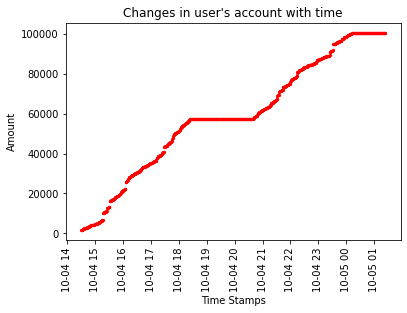

In [79]:
x = np.array(x).reshape(-1, 1)
y = np.array(y)

plt.scatter(df['Time Stamps'], df['Amount'], s = 5, color = 'red')
plt.xlabel('Time Stamps')
plt.ylabel('Amount')
plt.title("Changes in user's account with time")
plt.xticks(rotation = 'vertical')

x.shape

In [80]:
def modify_for_lstm(Data, period):
    N = Data.shape[0]
    res_x = [[Data[i + j] for i in range(period)] for j in range(N - period)]
    res_y = [Data[i + period] for i in range(N - period)]
    return res_x, res_y

steps = 50

X, Y = modify_for_lstm(y, steps)

X = np.array(X)
Y = np.array(Y)

N = Y.shape[0]
print(N)
X.shape

605


(605, 50)

In [105]:
train_size = int(0.7 * N)

y_train = Y[:train_size]
y_test = Y[train_size: N]

x_train = X[:train_size]
x_test = X[train_size: N]

print(y_train.shape, y_test.shape)

scalerX = StandardScaler()

x_train_scale = scalerX.fit_transform(x_train)
x_test_scale = scalerX.fit_transform(x_test)

scalerY = StandardScaler()

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(y_train.shape, y_test.shape)

y_train_scale = scalerY.fit_transform(y_train)
y_test_scale = scalerY.fit_transform(y_test)

(423,) (182,)
(423, 1) (182, 1)


In [82]:
model = Sequential()

model.add(LSTM((1), batch_input_shape = (None, steps, 1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.add(Dense(1))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 1)             12        
                                                                 
 lstm_11 (LSTM)              (None, 1)                 12        
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(x_train_scale, y_train_scale, epochs = 400, validation_data = (x_test_scale, y_test_scale))

Epoch 1/400
14/14 [==============================] - 3s 69ms/step - loss: 0.8048 - accuracy: 0.0000e+00 - val_loss: 0.8881 - val_accuracy: 0.0000e+00
Epoch 2/400
14/14 [==============================] - 0s 23ms/step - loss: 0.7964 - accuracy: 0.0000e+00 - val_loss: 0.8796 - val_accuracy: 0.0000e+00
Epoch 3/400
14/14 [==============================] - 0s 22ms/step - loss: 0.7881 - accuracy: 0.0000e+00 - val_loss: 0.8702 - val_accuracy: 0.0000e+00
Epoch 4/400
14/14 [==============================] - 0s 22ms/step - loss: 0.7790 - accuracy: 0.0000e+00 - val_loss: 0.8600 - val_accuracy: 0.0000e+00
Epoch 5/400
14/14 [==============================] - 0s 22ms/step - loss: 0.7694 - accuracy: 0.0000e+00 - val_loss: 0.8489 - val_accuracy: 0.0000e+00
Epoch 6/400
14/14 [==============================] - 0s 22ms/step - loss: 0.7588 - accuracy: 0.0000e+00 - val_loss: 0.8368 - val_accuracy: 0.0000e+00
Epoch 7/400
14/14 [==============================] - 0s 22ms/step - loss: 0.7466 - accuracy: 0.0000e

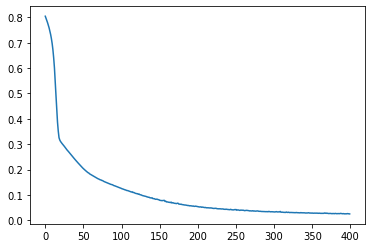

In [89]:
plt.plot(history.history['loss'])
plt.show()

423 605 182


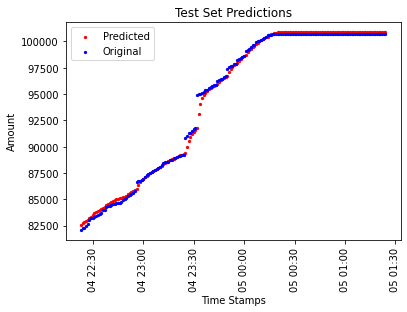

In [84]:
results_scaled = model.predict(x_test_scale)
results = scalerY.inverse_transform(results_scaled)
print(train_size, N, len(results))

plt.scatter(x_t[train_size + steps : N + steps], results, s = 5, color = 'red', label = 'Predicted')
plt.scatter(x_t[train_size + steps : N + steps], y_test, s = 5, color = 'blue', label = 'Original')
plt.xticks(rotation = 'vertical')
plt.xlabel('Time Stamps')
plt.ylabel('Amount')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

In [90]:
print("RMSE : ", rmse(y_test, results))
print("MSE : ", mean_squared_error(y_test, results))
print("MAE : ", mean_absolute_error(y_test, results))
print("R2 : ", r2_score(y_test, results))

RMSE :  [384.59873922]
MSE :  147916.19020905648
MAE :  229.29950590911855
R2 :  0.9967072656512178


In [106]:
df1 = pd.DataFrame()
forecasts = []
for i in range(5):
    values = y_test[-steps:]
    values = np.array(values).reshape(1, len(values))

    forecast_scaled = model.predict(values)
    forecast = scalerY.inverse_transform(forecast_scaled)
    forecasts.append(forecast)
    y_test = np.append(y_test, [forecast])

df1['Time Stamps'] = x_t[len(df) : len(df) + 5]
df1['Predictions'] = forecasts
df1

,Time Stamps,Predictions
0,2020-10-05 01:25:00,[[101371.01]]
1,2020-10-05 01:26:00,[[101371.01]]
2,2020-10-05 01:27:00,[[101371.01]]
3,2020-10-05 01:28:00,[[101371.01]]
4,2020-10-05 01:29:00,[[101371.01]]
